In [49]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from fiona import listlayers
import os
import json
import pandas as pd
from shapely.geometry import Polygon
from rasterio.crs import CRS
import fiona
import periodictable as pt

## Load data

In [39]:
type_of_data = "N_deposition"
current_dir = os.getcwd()
datasetdir = os.path.join(current_dir, '../data/raw', type_of_data)
path = os.path.join(datasetdir, "RIVM-MIL_HistorischeReeksStikstofdepositie_20241001.gpkg")

In [40]:
gdf = gpd.read_file(path)

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'RIVM-MIL_HistorischeReeksStikstofdepositie_20241001.gpkg': 'ndep_historisch_2005' (default), 'ndep_historisch_2006', 'ndep_historisch_2007', 'ndep_historisch_2008', 'ndep_historisch_2009', 'ndep_historisch_2010', 'ndep_historisch_2011', 'ndep_historisch_2012', 'ndep_historisch_2013', 'ndep_historisch_2014', 'ndep_historisch_2015', 'ndep_historisch_2016', 'ndep_historisch_2017', 'ndep_historisch_2018', 'ndep_historisch_2019', 'ndep_historisch_2020', 'ndep_historisch_2021', 'ndep_historisch_2022', 'ndep_historisch_2023'. Specify layer parameter to avoid this warning.
  result = read_func(


In [41]:
print(fiona.listlayers(path))

['ndep_historisch_2005', 'ndep_historisch_2006', 'ndep_historisch_2007', 'ndep_historisch_2008', 'ndep_historisch_2009', 'ndep_historisch_2010', 'ndep_historisch_2011', 'ndep_historisch_2012', 'ndep_historisch_2013', 'ndep_historisch_2014', 'ndep_historisch_2015', 'ndep_historisch_2016', 'ndep_historisch_2017', 'ndep_historisch_2018', 'ndep_historisch_2019', 'ndep_historisch_2020', 'ndep_historisch_2021', 'ndep_historisch_2022', 'ndep_historisch_2023']


In [42]:
# choose year
year = 2010
gdf = gpd.read_file(path, layer=f"ndep_historisch_{year}")
print(gdf.head())

   gdn_grid_cell_id       substance_name  year  deposition  \
0              1077  Totaal stikstof (N)  2010         556   
1              1078  Totaal stikstof (N)  2010         558   
2              1079  Totaal stikstof (N)  2010         560   
3              1334  Totaal stikstof (N)  2010         499   
4              1335  Totaal stikstof (N)  2010         503   

                                            geometry  
0  POLYGON ((236000 621000, 236000 622000, 237000...  
1  POLYGON ((237000 621000, 237000 622000, 238000...  
2  POLYGON ((238000 621000, 238000 622000, 239000...  
3  POLYGON ((213000 620000, 213000 621000, 214000...  
4  POLYGON ((214000 620000, 214000 621000, 215000...  


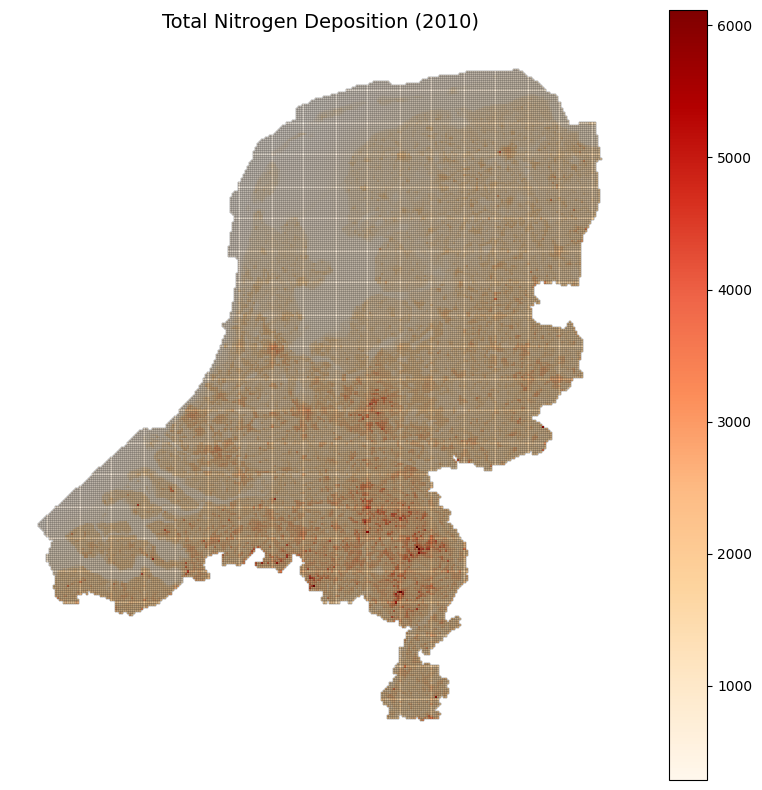

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="deposition", ax=ax, legend=True, cmap="OrRd", edgecolor="black", linewidth=0.2)

ax.set_title("Total Nitrogen Deposition (2010)", fontsize=14)
ax.set_axis_off()
plt.show()

## Crop image

In [20]:
def aoi_finder():
    # load Utrecht polygon coordinates
    utrecht_polygon_path = os.path.join(datasetdir, "..", "utrecht polygon.csv")
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    # define boundary line
    x1, y1 = 5.066884, 52.170366  # upper-left
    x2, y2 = 5.237030, 51.978896  # lower-right

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    # Filter polygon coordinates
    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    # Make sure polygon closes properly
    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

In [45]:
utrecht_mask = aoi_finder()
utrecht_mask_rd = utrecht_mask.to_crs(gdf.crs)
cropped_gdf = gpd.overlay(gdf, utrecht_mask_rd, how='intersection')

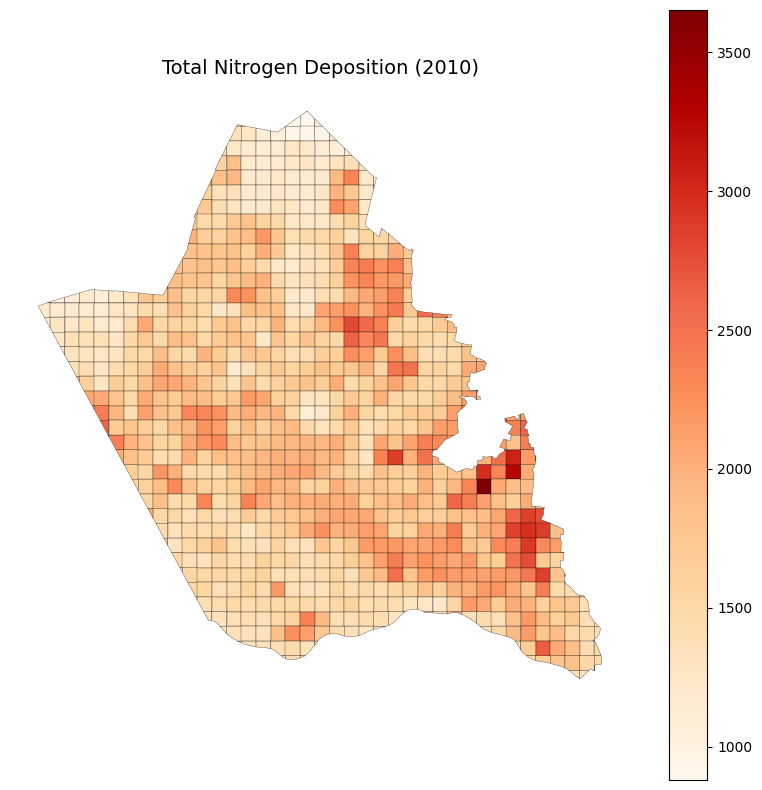

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
cropped_gdf.plot(column="deposition", ax=ax, legend=True, cmap="OrRd", edgecolor="black", linewidth=0.2)

ax.set_title("Total Nitrogen Deposition (2010)", fontsize=14)
ax.set_axis_off()
plt.show()

## Convert from moles to kg

In [53]:
MOLAR_MASS_N = pt.elements.symbol('N').mass
GRAMS_TO_KILOGRAMS = 1000

In [54]:
cropped_gdf["deposition_kg"] = cropped_gdf["deposition"] * MOLAR_MASS_N / 1000

In [55]:
cropped_gdf

,gdn_grid_cell_id,substance_name,year,deposition,geometry,deposition_kg
0,41032,Totaal stikstof (N),2010,1215,"POLYGON ((151432.081 478000, 151469.765 478026...",17.018505
1,41307,Totaal stikstof (N),2010,1808,"POLYGON ((147000 477000, 146676.473 477000, 14...",25.324656
2,41308,Totaal stikstof (N),2010,1529,"POLYGON ((147000 477058.165, 147002.943 477057...",21.416703
3,41311,Totaal stikstof (N),2010,880,"POLYGON ((151000 477000, 150019.983 477000, 15...",12.326160
4,41312,Totaal stikstof (N),2010,898,"POLYGON ((151000 477694.118, 151188.786 477827...",12.578286
...,...,...,...,...,...,...
847,51691,Totaal stikstof (N),2010,1511,"POLYGON ((170000 441000, 171000 441000, 171000...",21.164577
848,51692,Totaal stikstof (N),2010,1503,"POLYGON ((171000 441000, 171446.854 441000, 17...",21.052521
849,51970,Totaal stikstof (N),2010,1351,"POLYGON ((170000 440000, 170000 439452.664, 16...",18.923457
850,51971,Totaal stikstof (N),2010,1318,"MULTIPOLYGON (((170000 440000, 170625.758 4400...",18.461226


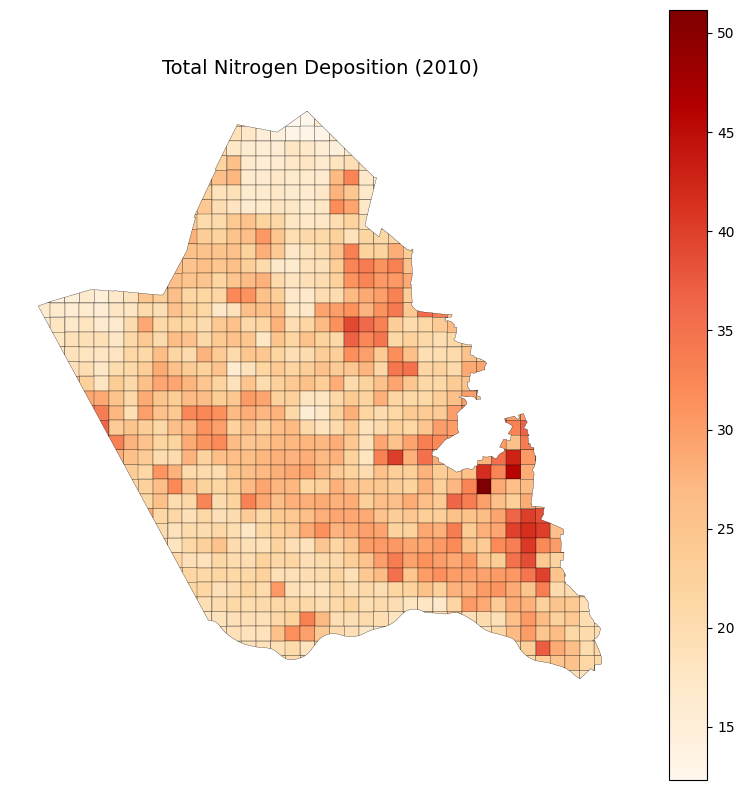

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
cropped_gdf.plot(column="deposition_kg", ax=ax, legend=True, cmap="OrRd", edgecolor="black", linewidth=0.2)

ax.set_title("Total Nitrogen Deposition (2010)", fontsize=14)
ax.set_axis_off()
plt.show()